In [1]:
import os
import sys
sys.path.append("./src")
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import fk_filter_2cones, peak_dvv
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

matplotlib.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'Helvetica'

In [2]:
### ACF file is big, stored on server
with h5py.File('/Users/shiqibin/projects/data_farm/data/autocorr_ch95_162_15_60Hz.hdf5', 'r') as f:
    corr_all_time = f['autocorr'][:]
samp_freq = 500 
corr_all_time.shape

(67, 482, 5001, 1)

In [ ]:
##backup
cutoff_lows =  [30, 30, 22, 35, 35, 35, 23, 23, 28, 27,
                26, 22, 22, 22, 22, 26, 22, 22, 22, 20,
                20, 20, 25, 25, 25, 39, 40, 40, 22, 20,
                20, 20, 10, 10, 10, 10, 42, 42, 42, 19,
                19, 40, 40, 42, 16, 16, 16, 18, 34, 30, 15]

cutoff_highs = [50, 50, 35, 60, 60, 60, 26, 26, 45, 41,
                42, 55, 55, 55, 55, 50, 50, 50, 46, 50,
                50, 50, 45, 40, 40, 50, 50, 50, 35, 35,
                35, 35, 20, 20, 20, 20, 70, 68, 70, 21,
                21, 70, 70, 70, 35, 35, 35, 35, 36, 40, 23]

threshold_all = [
    [0,  0.20, 3], [1,  0.35, 3], [2,  0.50, 2], [3,  0.5,1.6], [4,  0.4,1.6], 
    [5,  0.4, 2], [6,  0.70, 3], [7,  0.60, 3], [8,  0.45, 3], [9,  0.50, 3],
    [10, 0.20, 3], [11, 0.30, 3], [12, 0.35, 3], [13, 0.40, 3], [14, 0.60, 3], 
    [15, 0.60, 5], [16, 0.30, 3], [17, 0.30, 3], [18, 0.30, 3], [19, 0.30, 3], 
    [20, 0.30, 3], [21, 0.30, 3], [22, 0.35, 3], [23, 0.35, 3], [24, 0.35, 3], 
    [25, 0.35, 4], [26, 0.55, 3], [27, 0.35, 3], [28, 0.25, 3], [29, 0.40, 3],
    [30, 0.40, 3], [31, 0.40, 3], [32, 0.40, 3], [33, 0.40, 3], [34, 0.40, 3], 
    [35, 0.40, 3], [36, 0.40, 3], [37, 0.40, 3], [38, 0.25, 3], [39, 0.40, 3], 
    [40, 0.35, 3], [41, 0.25, 3], [42, 0.15, 3], [43, 0.30, 3], [44, 0.30, 3], 
    [45, 0.40, 3], [46, 0.40, 3], [47, 0.20, 3], [48, 0.30, 3], [49, 0.40, 3],
    [50, 0.50, 3]
]

In [75]:
cutoff_lows =  [30, 30, 22, 22, 25, 25, 23, 23, 28, 27,
                26, 22, 22, 22, 22, 26, 22, 22, 22, 20,
                20, 20, 25, 25, 25, 35, 35, 35, 22, 20,
                20, 20, 10, 10, 10, 10, 42, 42, 42, 19,
                19, 40, 40, 42, 16, 16, 16, 18, 34, 30, 15]

cutoff_highs = [50, 50, 34, 34, 34, 34, 26, 26, 45, 41,
                42, 55, 55, 55, 55, 50, 50, 50, 46, 50,
                50, 50, 45, 40, 40, 47, 50, 50, 35, 35,
                35, 35, 20, 20, 20, 20, 70, 68, 70, 21,
                21, 70, 70, 70, 35, 35, 35, 35, 36, 40, 23]

threshold_all = [
    [0,  0.20, 3], [1,  0.35, 3], [2,  0.5,2.5], [3,  0.70, 3], [4,  0.60, 3.0], 
    [5,  0.60, 3.0], [6,  0.70, 3], [7,  0.60, 3], [8,  0.45, 3], [9,  0.50, 3],
    [10, 0.20, 3], [11, 0.30, 3], [12, 0.35, 3], [13, 0.40, 3], [14, 0.60, 3], 
    [15, 0.60, 5], [16, 0.30, 3], [17, 0.30, 3], [18, 0.30, 3], [19, 0.30, 3], 
    [20, 0.30, 3], [21, 0.30, 3], [22, 0.35, 3], [23, 0.35, 3], [24, 0.35, 3], 
    [25, 0.4,1.8], [26, 0.50, 2], [27, 0.35, 2], [28, 0.25, 3], [29, 0.40, 3],
    [30, 0.40, 3], [31, 0.40, 3], [32, 0.40, 3], [33, 0.40, 3], [34, 0.40, 3], 
    [35, 0.40, 3], [36, 0.40, 3], [37, 0.40, 3], [38, 0.25, 3], [39, 0.40, 3], 
    [40, 0.35, 3], [41, 0.25, 3], [42, 0.15, 3], [43, 0.30, 3], [44, 0.30, 3], 
    [45, 0.40, 3], [46, 0.40, 3], [47, 0.20, 3], [48, 0.30, 3], [49, 0.40, 3],
    [50, 0.50, 3]
]

NameError: name 'cutoff_lows' is not defined

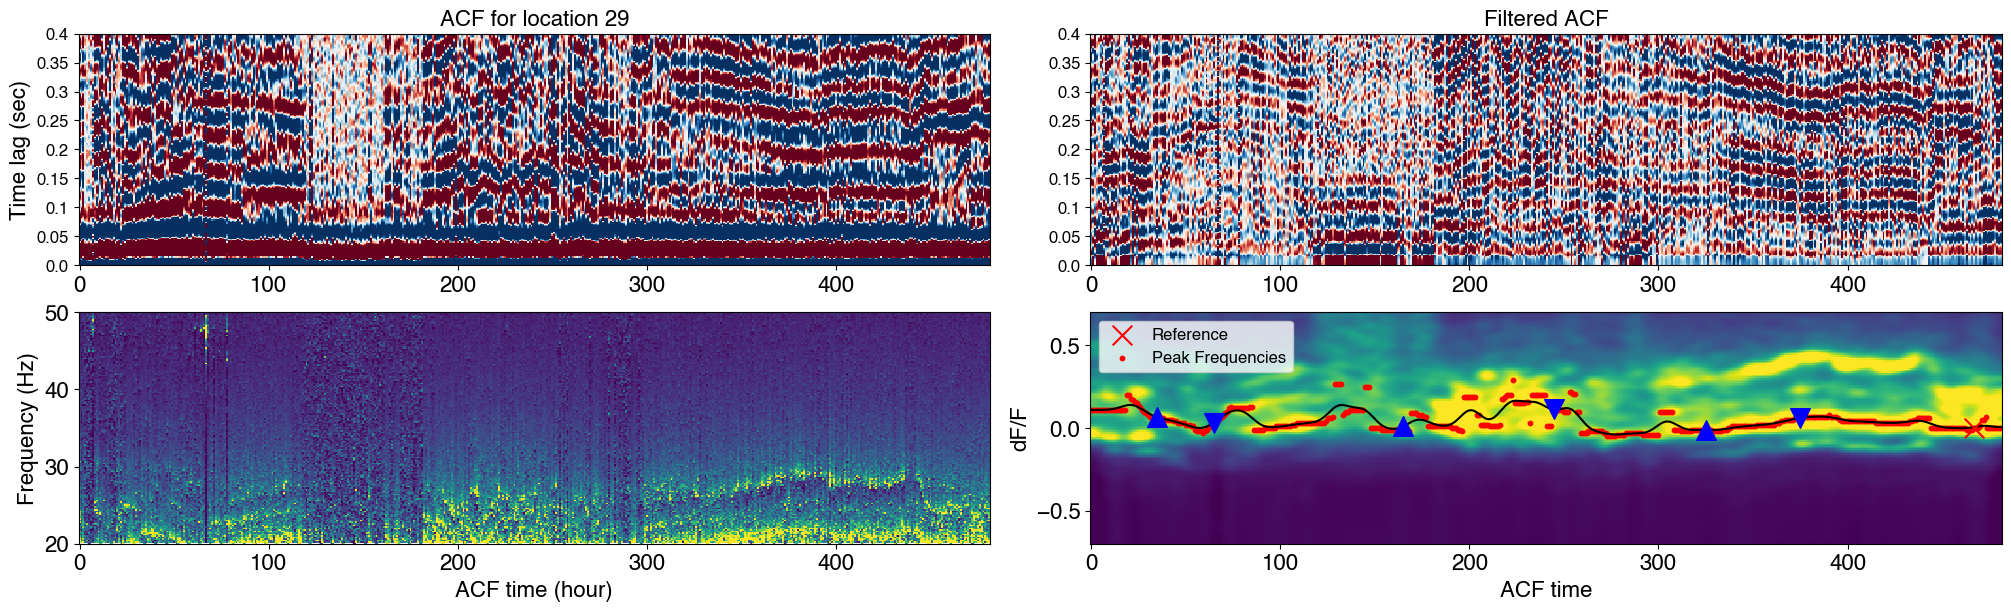

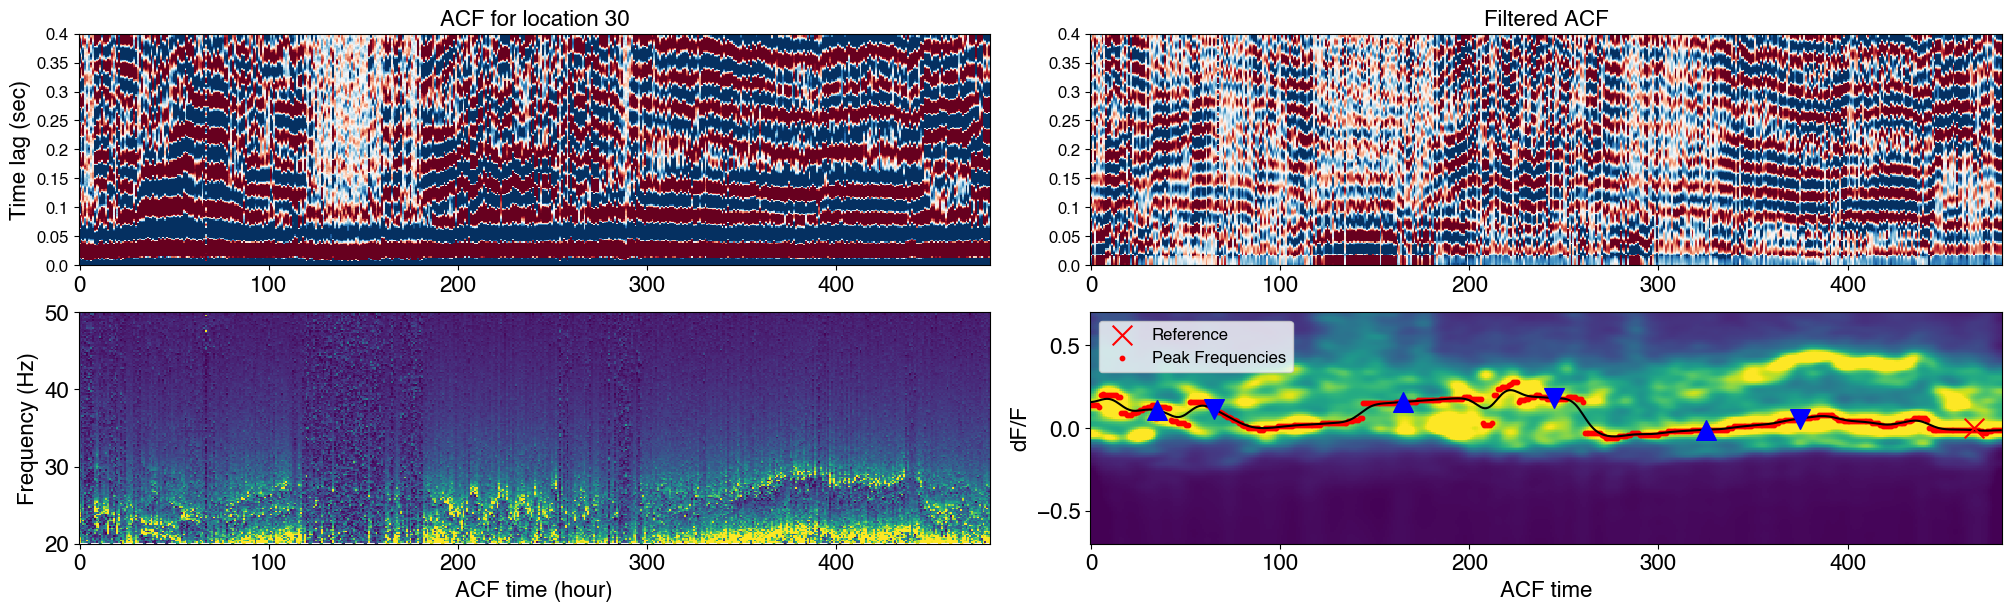

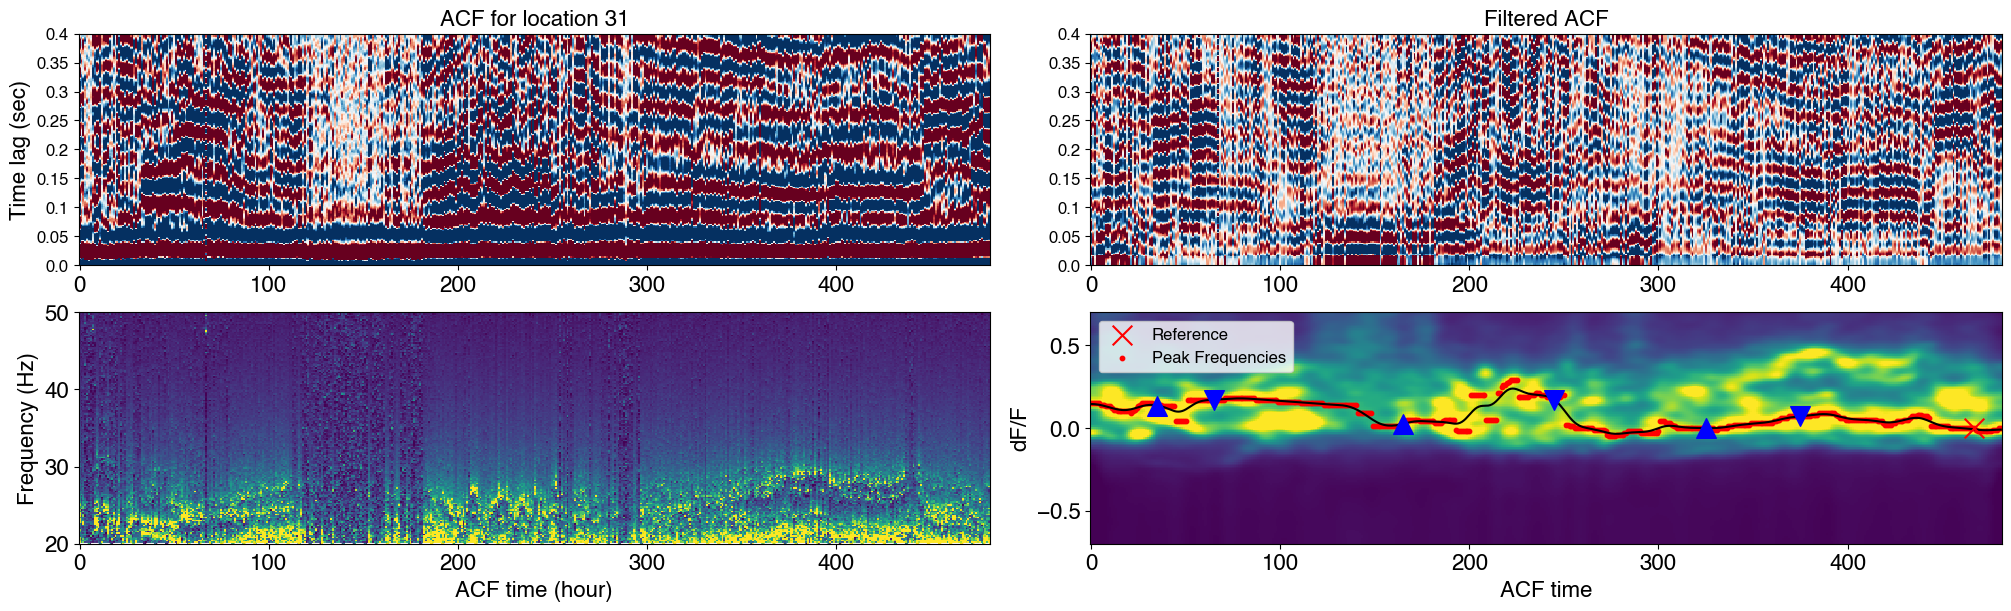

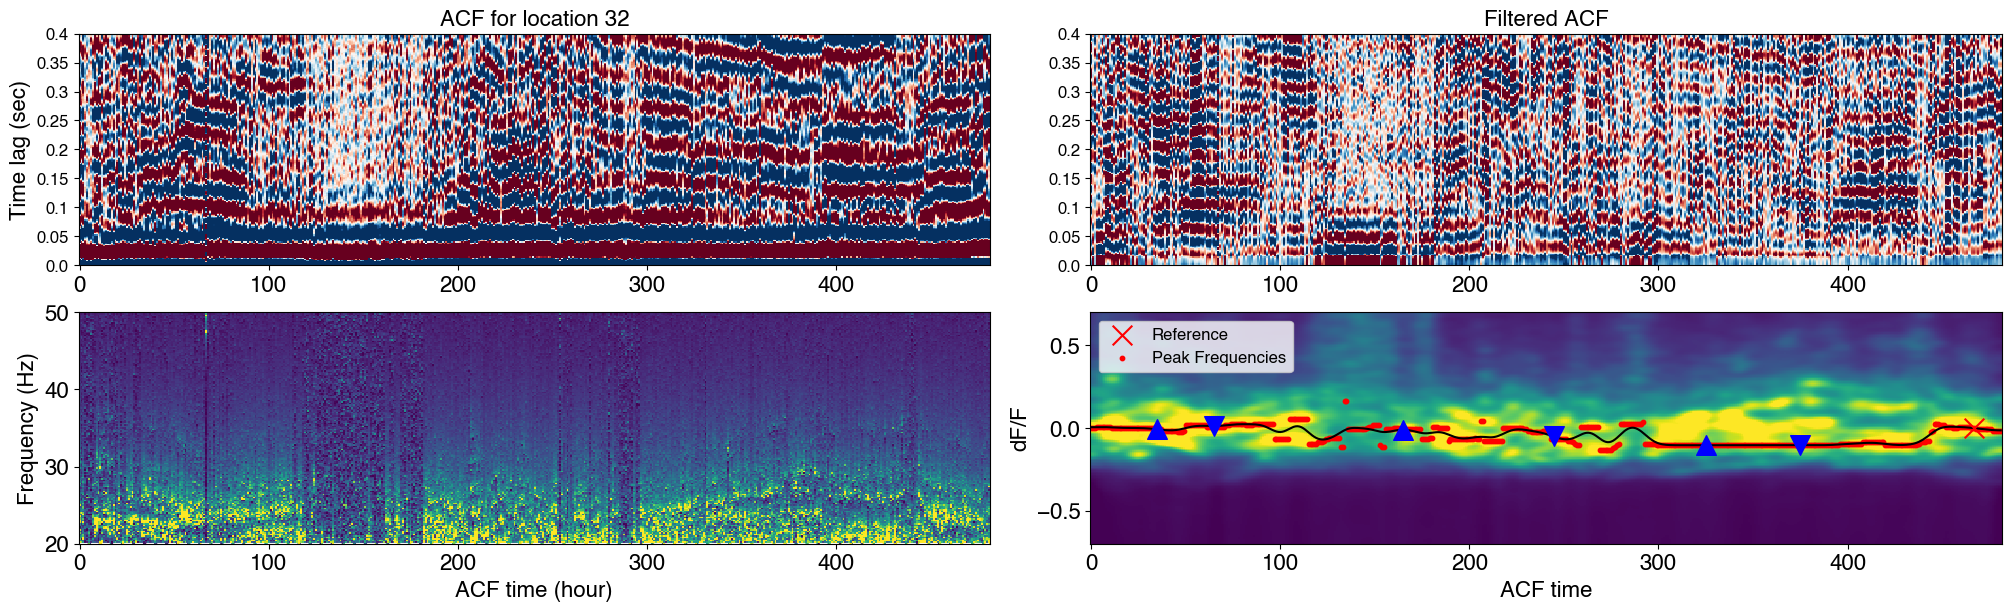

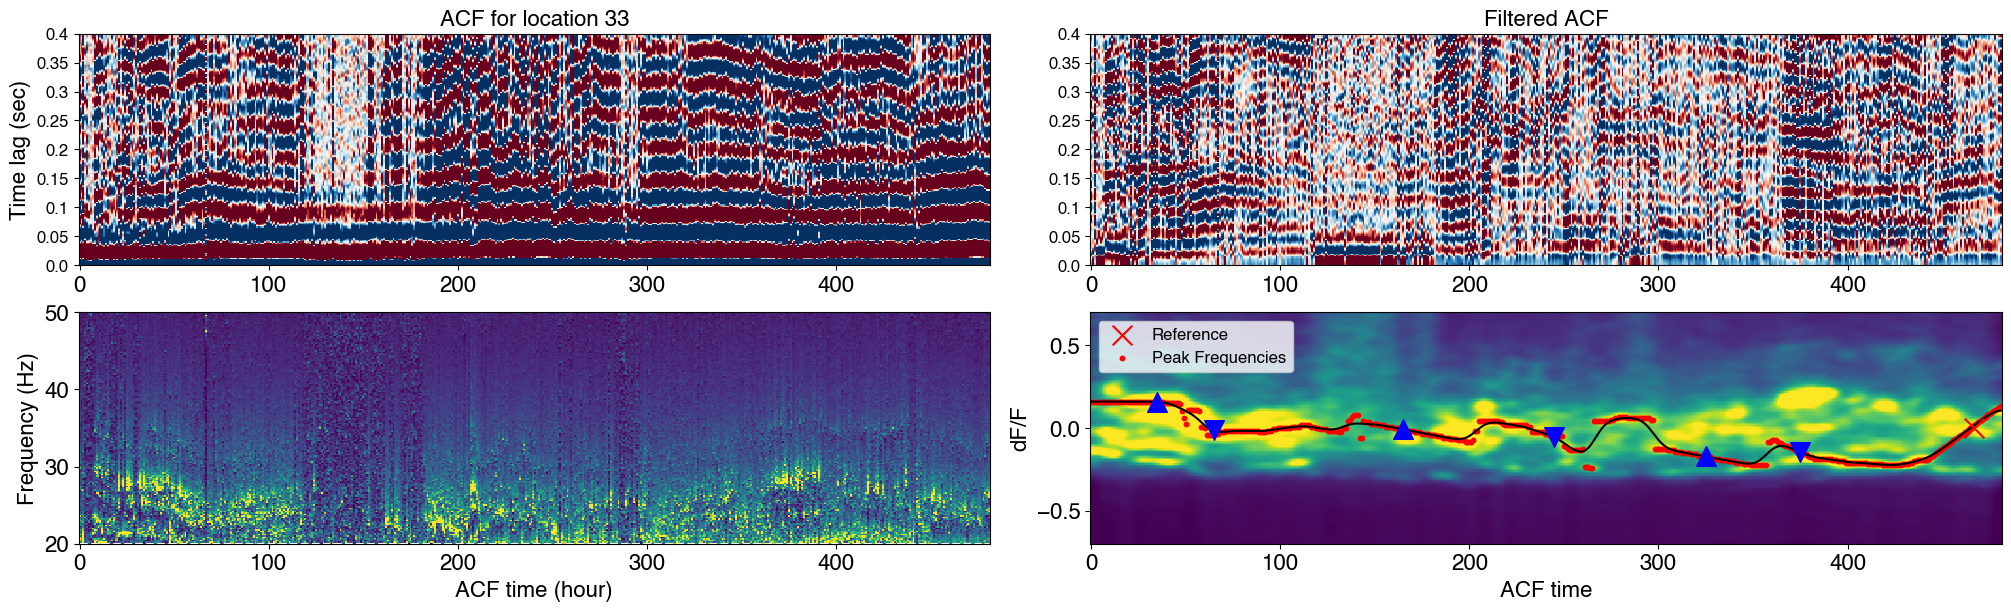

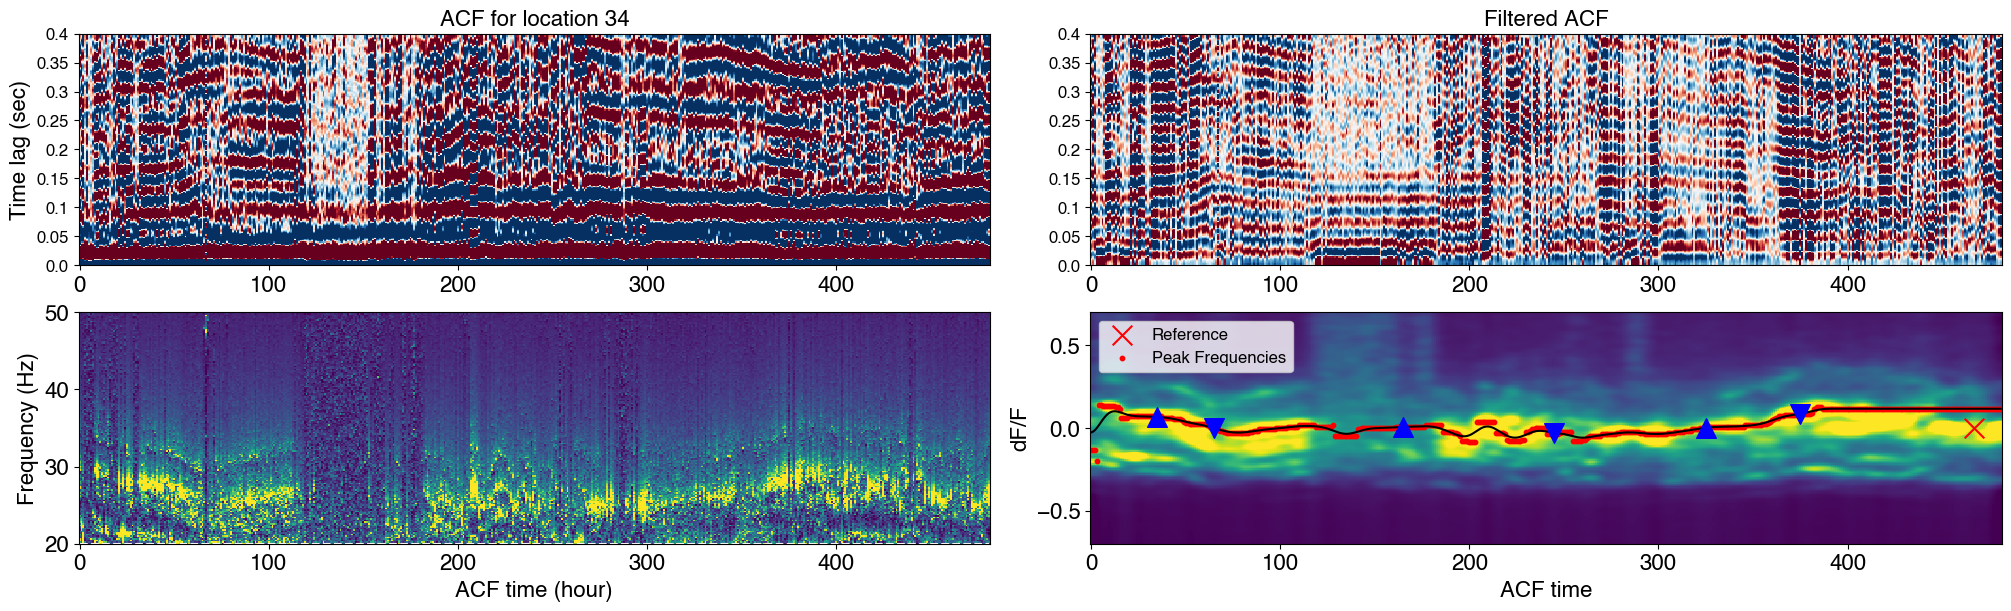

In [4]:
from scipy.signal import find_peaks

win_st = int(0.0*samp_freq)

corr_filtered = np.zeros((50, 482, 2501-win_st), dtype=corr_all_time.dtype)
final_peaks = np.zeros((50, 482), dtype=np.float32)
v_points = np.zeros((50, 6), dtype=np.float32)

for loc in range(29,35):
    # thrshold = threshold_all[loc][1]
    # cutoff_low = cutoff_lows[loc]
    # cutoff_high = cutoff_highs[loc]
    cutoff_low = 20
    cutoff_high = 55
    thrshold =0.3


    data_plot=corr_all_time[loc, :, 2500+win_st:, 0].T * 2
    x=np.arange(data_plot.shape[1])
    y=np.arange(data_plot.shape[0])

    ### filter the data
    order = 4
    nyq = 0.5 * samp_freq
    low = cutoff_low / nyq
    high = cutoff_high / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, data_plot, axis=0)
    filtered_signal = (filtered_signal - np.mean(filtered_signal, axis=1, keepdims=True)) \
    / np.std(filtered_signal, axis=1, keepdims=True)
    corr_filtered[loc, :, :] = filtered_signal.T

    ### spectrogram
    time_steps = data_plot.shape[0]
    half_idx = time_steps // 2  # FFT is symmetric

    fft_data = np.fft.fft(data_plot, axis=0)  # FFT along time
    frequencies = np.fft.fftfreq(time_steps, d=1/samp_freq)[:half_idx]
    acf_spec = np.abs(fft_data)[:half_idx, :]    # Take positive part
    q1 = np.percentile(acf_spec, 20)
    q2 = np.percentile(acf_spec, 99)

    fft_filtered = np.fft.fft(filtered_signal, axis=0)  # FFT along time
    filtered_spec = np.abs(fft_filtered)[:half_idx, :]  # Take positive part  
    

    # denoise filtered spectra
    filt_data, filtered_fk, fk2d = fk_filter_2cones(filtered_spec.T, 
                                                    w1=0.002, w2=0.005, 
                                                    cone1=True, cone2=False)
    image = filt_data.real.T[:,:]  # only real part
    dvv_image = gaussian_filter(image, sigma=(0.5, 1))
    filt_data, filtered_fk, fk2d = fk_filter_2cones(dvv_image.T, 
                                                    w1=0.004, w2=0.005, 
                                                    cone1=True, cone2=False)
    image = filt_data.real.T[:,:]  # only real part
    dvv_image = gaussian_filter(image, sigma=(1, 2))
    filt_data, filtered_fk, fk2d = fk_filter_2cones(dvv_image.T, 
                                                    w1=0.006, w2=0.005, 
                                                    cone1=True, cone2=False)
    image = filt_data.real.T[:,:]  # only real part
    dvv_image = gaussian_filter(image, sigma=(1.5, 3))
    dvv_image = dvv_image / np.std(dvv_image) 
    q3 = np.percentile(dvv_image, 20)
    q4 = np.percentile(dvv_image, 99)+0.5 


    # Plotting
    ##############
    fig, ax = plt.subplots(2, 2, figsize=(20,6), constrained_layout=True)

    # Find the peak frequency of the last 10 columns
    ref_spec = np.mean(filtered_spec[:, -30:], axis=1)
    peak_freq_indice = np.argmax(ref_spec)
    ref_freq = frequencies[peak_freq_indice]

    # find all the peaks in the filtered data
    peak_freq_indices = np.argmax(dvv_image, axis=0)
    if loc > 1 and loc < 6:
        peak_freq_indices[100:180] = np.array([find_peaks(dvv_image[:, i], 
                            height=threshold_all[loc][2])[0][-1] for i in range(100,180)])
        
    if loc > 24 and loc < 28:
        peak_freq_indices[0:20] = np.array([find_peaks(dvv_image[:, i], 
                            height=threshold_all[loc][2])[0][-1] for i in range(0,20)])
        peak_freq_indices[120:200] = np.array([find_peaks(dvv_image[:, i], 
                            height=threshold_all[loc][2])[0][-1] for i in range(120,200)])
        peak_freq_indices[320:482] = np.array([find_peaks(dvv_image[:, i], 
                            height=threshold_all[loc][2])[0][-1] for i in range(320,482)])

    peak_values = peak_dvv(peak_freq_indices, ax[1,1], thrs=thrshold)
    peak_freqs = frequencies[peak_values] / ref_freq - 1
    peak_freqs_smooth = gaussian_filter1d(peak_freqs, sigma=5)
    final_peaks[loc, :] = peak_freqs_smooth+1

    v_points[loc, 0] = np.mean(peak_freqs_smooth[30:40])
    v_points[loc, 1] = np.mean(peak_freqs_smooth[60:70])
    v_points[loc, 2] = np.mean(peak_freqs_smooth[160:170])
    v_points[loc, 3] = np.mean(peak_freqs_smooth[240:250])
    v_points[loc, 4] = np.mean(peak_freqs_smooth[320:330])
    v_points[loc, 5] = np.mean(peak_freqs_smooth[370:380])

    ax[0,0].pcolormesh(x, y, data_plot, shading='auto', vmin=-0.1, vmax=0.1, cmap = 'RdBu')
    ax[0,1].pcolormesh(x, y, filtered_signal, shading='auto', vmin=-1, vmax=1, cmap = 'RdBu')
    ax[0,0].set_yticks(np.arange(0, data_plot.shape[0], 25)) 
    ax[0,0].set_yticklabels((np.arange(0, data_plot.shape[0], 25))/samp_freq, fontsize = 12)
    ax[0,1].set_yticks(np.arange(0, data_plot.shape[0], 25)) 
    ax[0,1].set_yticklabels((np.arange(0, data_plot.shape[0], 25))/samp_freq, fontsize = 12)
    ax[0,0].set_ylabel("Time lag (sec)", fontsize = 16)
    ax[0,0].set_title(f"ACF for location {loc}", fontsize = 16)
    ax[0,1].set_title("Filtered ACF", fontsize = 16)
    ax[0,0].set_ylim(0, 200)
    ax[0,1].set_ylim(0, 200)

    ax[1,0].pcolormesh(x, frequencies, acf_spec, shading='auto', cmap='viridis', vmin=q1, vmax=q2)
    ax[1,0].hlines([cutoff_low, cutoff_high], xmin=x[0], xmax=x[-1], colors='w', linestyles='dashed', linewidth=1.5)
    ax[1,0].set_ylabel("Frequency (Hz)", fontsize = 16)
    ax[1,0].set_xlabel("ACF time (hour)", fontsize = 16)
    ax[1,0].set_ylim(20, 50)

    
    ax[1,1].pcolormesh(x, frequencies/ref_freq - 1, dvv_image, shading='auto', cmap='viridis', vmin=q3, vmax=q4)
    ax[1,1].set_ylabel("dF/F", fontsize = 16)
    ax[1,1].set_xlabel("ACF time", fontsize = 16)
    ax[1,1].set_ylim(-0.7, 0.7)

    # Plot the peak frequencies
    ax[1,1].scatter(x[-15], 0, label='Reference', color='red', marker='x', s=200, zorder=5)
    ax[1,1].scatter(x[375], v_points[loc, 5], color='b', marker='v', s=200, zorder=5)
    ax[1,1].scatter(x[325], v_points[loc, 4], color='b', marker='^', s=200, zorder=5)
    ax[1,1].scatter(x[245], v_points[loc, 3], color='b', marker='v', s=200, zorder=5)
    ax[1,1].scatter(x[165], v_points[loc, 2], color='b', marker='^', s=200, zorder=5)
    ax[1,1].scatter(x[65], v_points[loc, 1], color='b', marker='v', s=200, zorder=5)
    ax[1,1].scatter(x[35], v_points[loc, 0], color='b', marker='^', s=200, zorder=5)
    ax[1,1].scatter(x, peak_freqs, label='Peak Frequencies', color='red', s=10)
    ax[1,1].plot(x, peak_freqs_smooth, color='k')
    ax[1,1].legend(fontsize=12, loc='upper left')


with h5py.File('/Users/shiqibin/projects/data_farm/data/autocorr_15_90Hz_bandpassed.hdf5', 'w') as f:
    f.create_dataset('autocorr', data=corr_filtered)
    f.create_dataset('cutoff_lows', data=cutoff_lows)
    f.create_dataset('cutoff_highs', data=cutoff_highs)
    f.create_dataset('v_points', data=v_points)

In [79]:
with h5py.File('/Users/shiqibin/projects/data_farm/data/final_peaks_15_90Hz_fromspec_smooth.h5', 'w') as f:
    f.create_dataset('final_peaks', data=final_peaks)